In [1]:
!pip install k-wave-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.1/819.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-pytho

## Modelling A Circular Piston

This example models a circular piston transducer in 3D. The on-axis  pressure is compared with the analytical expression from Pierce's _"Acoustics: An Introduction to its Physical Principles and Applications"_

First, define the settings, import the libraries and functions needed

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from kwave.data import Vector

from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.ksensor import kSensor
from kwave.ksource import kSource
from kwave.utils.filters import extract_amp_phase
from kwave.utils.math import round_even
from kwave.utils.kwave_array import kWaveArray
from kwave.utils.signals import create_cw_signals

from kwave.kspaceFirstOrder3D import kspaceFirstOrder3D

from kwave.options.simulation_options import SimulationOptions
from kwave.options.simulation_execution_options import SimulationExecutionOptions

The parameters of the system are defined belowil.

In [3]:
# medium parameters
c0: float            = 1500.0  # sound speed [m/s]
rho0: float          = 1000.0  # density [kg/m^3]

# source parameters
source_f0            = 1.0e6              # source frequency [Hz]
source_diameter      = 10e-3              # bowl aperture diameter [m]
source_amp           = np.array([1.0e6])  # source pressure [Pa]
source_phase         = np.array([0.0])    # source phase [radians]

# grid parameters
axial_size: float    = 32.0e-3  # total grid size in the axial dimension [m]
lateral_size: float  = 23.0e-3  # total grid size in the lateral dimension [m]

# computational parameters
ppw: int             = 3      # number of points per wavelength
t_end: float         = 40e-6  # total compute time [s] (this must be long enough to reach steady state)
record_periods: int  = 1      # number of periods to record
cfl: float           = 0.3    # CFL number
bli_tolerance: float = 0.05   # tolerance for truncation of the off-grid source points
upsampling_rate: int = 10     # density of integration points relative to grid
verbose_level: int   = 0      # verbosity of k-wave executable

## Grid

Construct the grid via the `kgrid` class

In [4]:
# calculate the grid spacing based on the PPW and F0
dx: float = c0 / (ppw * source_f0)   # [m]

# compute the size of the grid
Nx: int = round_even(axial_size / dx)
Ny: int = round_even(lateral_size / dx)
Nz: int = Ny

grid_size_points = Vector([Nx, Ny, Nz])
grid_spacing_meters = Vector([dx, dx, dx])

# create the k-space grid
kgrid = kWaveGrid(grid_size_points, grid_spacing_meters)

# compute points per period
ppp: int = np.round(ppw / cfl)

# compute corresponding time spacing
dt: float = 1.0 / (ppp * source_f0)

# create the time array using an integer number of points per period
Nt: int = int(np.round(t_end / dt))
kgrid.setTime(Nt, dt)

# calculate the actual CFL and PPW
print('points-per-period: ' + str(c0 / (dx * source_f0)) + ' and CFL number: ' + str(c0 * dt / dx))

points-per-period: 3.0 and CFL number : 0.3


## Source

Define the source, using the `kWaveArray` class and the `add_bowl_element` method along with a continuous wave signal.

In [5]:
source = kSource()

# create time varying source
source_sig = create_cw_signals(np.squeeze(kgrid.t_array), source_f0, source_amp, source_phase)

# create empty kWaveArray
karray = kWaveArray(bli_tolerance=bli_tolerance,
                    upsampling_rate=upsampling_rate,
                    single_precision=True)

# add disc shaped element at one end of the grid
karray.add_disc_element([kgrid.x_vec[0].item(), 0.0, 0.0], source_diameter, [0.0, 0.0, 0.0])

# assign binary mask
source.p_mask = karray.get_array_binary_mask(kgrid)

# assign source signals
source.p = karray.get_distributed_source_signal(kgrid, source_sig)

## Medium

The medium is water. Neither nonlinearity nor attenuation are considered.

In [6]:
# assign medium properties
medium = kWaveMedium(sound_speed=c0, density=rho0)

## Sensor

The sensor class defines what acoustic information is recorded.

A mask records all data except for at the location of the source.

In [7]:
sensor = kSensor()

# set sensor mask to record central plane, not including the source point
sensor.mask = np.zeros((Nx, Ny, Nz), dtype=bool)
sensor.mask[1:, :, Nz // 2] = True

# record the pressure
sensor.record = ['p']

# record only the final few periods when the field is in steady state
sensor.record_start_index = kgrid.Nt - (record_periods * ppp) + 1

## Simulation

In [8]:
simulation_options = SimulationOptions(pml_auto=True,
                                       data_recast=True,
                                       save_to_disk=True,
                                       save_to_disk_exit=False,
                                       pml_inside=False)

execution_options = SimulationExecutionOptions(is_gpu_simulation=True,
                                               delete_data=False,
                                               verbose_level=0)

sensor_data = kspaceFirstOrder3D(medium=deepcopy(medium),
                                 kgrid=deepcopy(kgrid),
                                 source=deepcopy(source),
                                 sensor=deepcopy(sensor),
                                 simulation_options=simulation_options,
                                 execution_options=execution_options)

## Post-processing

Extract amplitude from the sensor data, using the Fourier transform. The data can be reshaped to match the spatial extents of the domain. The on-axis pressure amplitudes found and axes for plotting defined.

In [9]:
# extract amplitude from the sensor data
amp, _, _  = extract_amp_phase(sensor_data['p'].T, 1.0 / kgrid.dt, source_f0, dim=1, fft_padding=1, window='Rectangular')

# reshape data
amp = np.reshape(amp, (Nx-1, Ny), order='F')

# extract pressure on axis
amp_on_axis = amp[:, Ny // 2]

# define axis vectors for plotting
x_vec = kgrid.x_vec[1:, :] - kgrid.x_vec[0]
y_vec = kgrid.y_vec

## Analytical Solution

An analytical expression cam be found in Pierce<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1). Given a transdcuer of radius $a$, wavenumber $k= 2 \pi f / c$, where $f$ is the frequency, speed of sound $c$, and a unit normal vector to transducer surface, $\hat{v}_n$, the on-axis pressure is given by

$$
p_{\mathrm{ref}}(z) = −2 \, i \, \rho \, c \, \hat{v}_n \, e^{i k \left( z + \sqrt{z^2 + a^2} \right) \big/ 2} \sin \left( \dfrac{k}{2} \left( \sqrt{z^2 + a^2} − z \right) \right).
$$

<a name="cite_note-1"></a>[<sup>[1]</sup>](#cite_ref-1) A. D. Pierce, _"Acoustics: An Introduction to its Physical Principles and Applications"_ Springer (2019).

In [10]:
# calculate the wavenumber
k: float = 2.0 * np.pi * source_f0 / c0

# define radius and axis
a: float = source_diameter / 2.0
x_max: float = Nx * dx
delta_x: float = x_max / 10000.0
x_ref: float = np.arange(0.0, x_max + delta_x, delta_x, dtype=float)

# calculate the analytical solution for a piston in an infinite baffle
# for comparison (Eq 5-7.3 in Pierce)
r_ref = np.sqrt(x_ref**2 + a**2)
p_ref = source_amp * np.abs(2.0 * np.sin((k * r_ref - k * x_ref) / 2.0))

# get analytical solution at exactly the same points as k-Wave
r_vec = np.sqrt(x_vec**2 + a**2)
p_ref_kw = source_amp * np.abs(2.0 * np.sin((k * r_vec - k * x_vec) / 2.0))

# calculate error
L2_error: float = 100 * np.linalg.norm(p_ref_kw - amp_on_axis, ord=2)
Linf_error: float = 100 * np.linalg.norm(p_ref_kw -  amp_on_axis, ord=np.inf)

## Visualisation

First plot the pressure along the focal axis of the piston

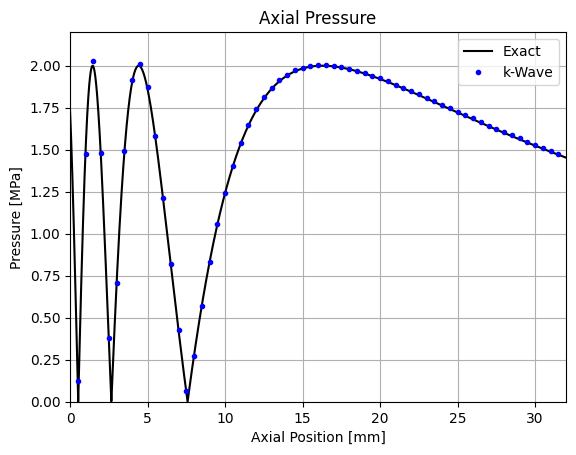

In [11]:
fig1, ax1 = plt.subplots(1, 1)
ax1.plot(1e3 * x_ref, 1e-6 * p_ref, 'k-', label='Exact')
ax1.plot(1e3 * x_vec, 1e-6 * amp_on_axis, 'b.', label='k-Wave')
ax1.legend()
ax1.set(xlabel='Axial Position [mm]',
        ylabel='Pressure [MPa]',
        title='Axial Pressure')
ax1.set_xlim(0.0, 1e3 * axial_size)
ax1.set_ylim(0.0, 1.1 * source_amp * 2e-6)
ax1.grid()

Next plot the source mask (pml is outside the grid in this example). This means getting the grid weights first

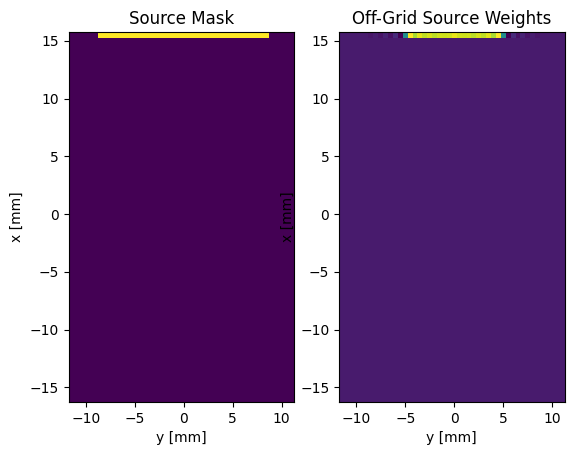

In [23]:
# get grid weights
grid_weights = karray.get_array_grid_weights(kgrid)

fig2, (ax2a, ax2b) = plt.subplots(1, 2)
ax2a.pcolormesh(1e3 * np.squeeze(kgrid.y_vec),
                1e3 * np.squeeze(kgrid.x_vec),
                np.flip(source.p_mask[:, :, Nz // 2], axis=0),
                shading='nearest')
ax2a.set(xlabel='y [mm]',
         ylabel='x [mm]',
         title='Source Mask')
ax2b.pcolormesh(1e3 * np.squeeze(kgrid.y_vec),
                1e3 * np.squeeze(kgrid.x_vec),
                np.flip(grid_weights[:, :, Nz // 2], axis=0),
                shading='nearest')
ax2b.set_xlabel('y [mm]')
ax2b.set_ylabel('x [mm]')
_ = ax2b.set_title('Off-Grid Source Weights')

Finally, plot the pressure field

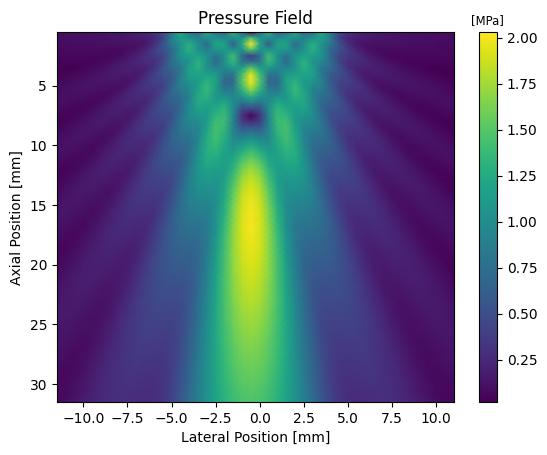

In [13]:
fig3, ax3 = plt.subplots(1, 1)
p3 = ax3.pcolormesh(1.0e3 * np.squeeze(y_vec),
                    1.0e3 * np.squeeze(x_vec),
                    np.flip(amp, axis=1) / 1.0e6,
               shading='gouraud')
ax3.set(xlabel='Lateral Position [mm]',
        ylabel='Axial Position [mm]',
        title='Pressure Field')
ax3.set_ylim(1.0e3 * x_vec[-1],  1.0e3 * x_vec[0])
cbar3 = fig3.colorbar(p3, ax=ax3)
_ = cbar3.ax.set_title('[MPa]', fontsize='small')